In [1]:
from astropy.io import fits
from scipy import *
import numpy as np
from pylab import *
#from astropy.coordinates import SkyCoord
import astropy.units as units
from IPython.display import Image
#from astropy.coordinates import FK5, ICRS
from astropy import units as u
from astropy.coordinates import match_coordinates_sky
#import WLanalysis
from scipy.interpolate import interp2d,NearestNDInterpolator
from scipy.interpolate import interp1d
import os
#from apogee.spec import continuum


In [2]:
#from __future__ import absolute_import, division, print_function # Python2 compatibility
apodir = '/Users/jia/Dropbox/smbhs/ApogeeLine/'

os.chdir(apodir+'binspec')

import utils
import spectral_model
import fitting

# read in all individual neural networks we'll need. 
NN_coeffs_norm = utils.read_in_neural_network(name = 'normalized_spectra')
NN_coeffs_flux = utils.read_in_neural_network(name = 'unnormalized_spectra')
NN_coeffs_R = utils.read_in_neural_network(name = 'radius')
NN_coeffs_Teff2_logg2 = utils.read_in_neural_network(name = 'Teff2_logg2')
wavelength = utils.load_wavelength_array()
# print (wavelength.shape)

In [3]:
def read_spec(fitsfile, get_vhelio=0):    
    ihdulist = fits.open(fitsfile)
    idate = ihdulist[0].header['DATE-OBS'][:10]
    ispec = ihdulist[1].data
    ierr = ihdulist[2].data
    imask = ihdulist[3].data
    ipass = ones(shape=imask.shape)
    for ibit in (0,1,2,3,4,5,6,7,12,13,14):
        ipass[~logical_not(imask & 2**ibit)]=0
    ilambda = ihdulist[4].data
    iidx=ilambda.flatten()
#     ispec_mask = interp1d(ilambda[where(ipass)], ispec[where(ipass)],
#                           fill_value="extrapolate")(ilambda.flatten())
#     ierr_mask = interp1d(ilambda[where(ipass)], ierr[where(ipass)],
#                           fill_value="extrapolate")(ilambda.flatten())
#     icont = continuum.fitApvisit(ispec_mask, ierr_mask, 
#             ilambda.flatten(),deg=4, niter=10, usigma=3., lsigma=0.1,).reshape(3,-1)[[2,1,0]]
    if get_vhelio:
        vhelio = ihdulist[0].header['VHELIO']
        return ilambda, ispec, ierr, ipass, idate, vhelio
    else:
        return ilambda, ispec, ierr, ipass, idate

/Users/jia/anaconda/lib/python2.7/site-packages/astropy/config/configuration.py:423: AstropyDeprecationWarning: Config parameter 'enabled_record_valued_keyword_cards' in section [io.fits] of the file '/Users/jia/.astropy/config/astropy.cfg' is deprecated. Use 'enable_record_valued_keyword_cards' in section [io.fits] instead.
  AstropyDeprecationWarning)



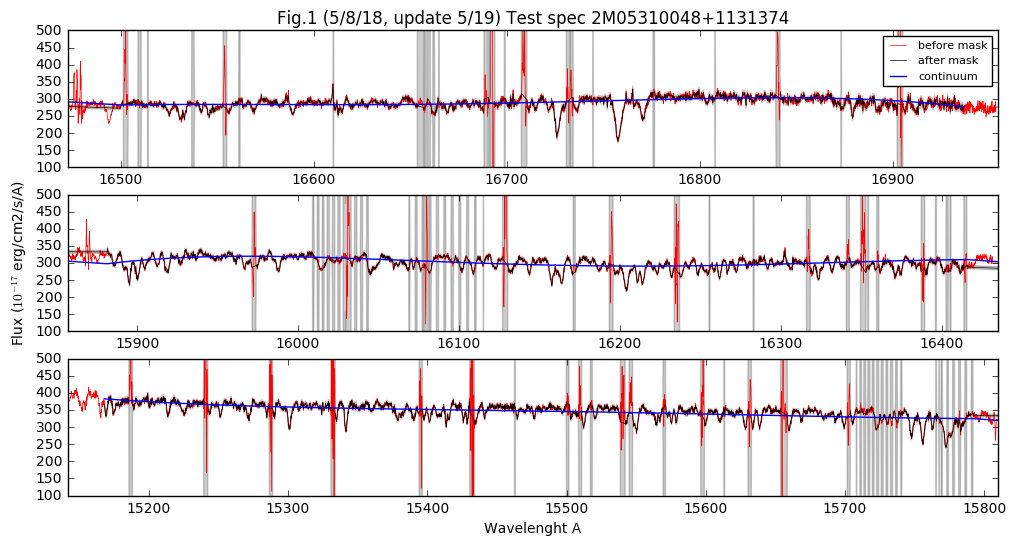

In [4]:
apoid_candidates = os.listdir(apodir+'specs_visit/MS')[1:]
iapoid = '2M05310048+1131374'#apoid_candidates[7]
ifitsfn = apodir+'specs_visit/MS/%s/%s'%(iapoid,os.listdir(apodir+'specs_visit/MS/%s'%(iapoid))[0])
ilambda, ispec, ierr, ipass, idate = read_spec(ifitsfn)

######## manually inflate the error by a factor of 200 ######
ierr[where(ipass==0)]*=100

data_spec = interp1d(ilambda[where(ipass)].flatten(), ispec[where(ipass)].flatten())(wavelength)
specerr = interp1d(ilambda.flatten(), ierr.flatten())(wavelength)
icont = utils.get_apogee_continuum(wavelength, data_spec, spec_err = specerr, cont_pixels = None)   

f, axes=subplots(3,1,figsize=(12,6))
for i in range(len(ilambda)):
    axes[i].fill_between(wavelength, data_spec-specerr, data_spec+specerr, color='k',alpha=0.2)
    axes[i].plot(ilambda[i], ispec[i], 'r-',lw=0.5,label='before mask')
    axes[i].plot(wavelength, data_spec, 'k-',lw=0.5,label='after mask')
    axes[i].set_xlim(amin(ilambda[i]),amax(ilambda[i]))
    #axes[i].set_ylim(0.5,1.5)
    axes[i].set_ylim(100,500)
    axes[i].plot(wavelength, icont,'b-',lw=1,label='continuum')
axes[1].set_ylabel('Flux ($10^{-17}$ erg/cm2/s/A)') 
axes[-1].set_xlabel('Wavelenght A')
axes[0].set_title('Fig.1 (5/8/18, update 5/19) Test spec '+iapoid)
axes[0].legend(fontsize=8,loc='best')
show()
#print imask[1]

In [5]:
def kareem_fit(ifitsfn, iapoid, star='MS'):
    ilambda, ispec, ierr, ipass, idate = read_spec(ifitsfn)

    ######### interpolate to grid wavelength, and subtract continuum
    data_spec = interp1d(ilambda[where(ipass)].flatten(), ispec[where(ipass)].flatten(), fill_value="extrapolate")(wavelength)
    specerr = interp1d(ilambda.flatten(), ierr.flatten(), fill_value="extrapolate")(wavelength)
    icont = utils.get_apogee_continuum(wavelength, data_spec, spec_err = None, cont_pixels = None)   
    data_spec/=icont
    specerr/=icont
    ################ fit single-star model
    popt_single, pcov, single_spec = fitting.fit_normalized_spectrum_single_star_model(norm_spec = data_spec, 
            spec_err = specerr, NN_coeffs_norm = NN_coeffs_norm, NN_coeffs_flux = NN_coeffs_flux, 
            p0 = None, num_p0 = 1)

    ############### fit binary model. 
    # use the best-fit single-star model ("popt_single") as a starting guess. 
    popt_binary, pcov2, bin_spec = fitting.fit_normalized_spectrum_binary_model(norm_spec = data_spec, 
            spec_err = specerr, NN_coeffs_norm = NN_coeffs_norm, NN_coeffs_flux = NN_coeffs_flux, 
            NN_coeffs_R = NN_coeffs_R, NN_coeffs_Teff2_logg2 = NN_coeffs_Teff2_logg2,
            p0_single = popt_single, num_p0 = 10)

    popt_N3, pcov3, N3_spec = fitting.fit_normalized_spectrum_N(norm_spec = data_spec, 
            spec_err = specerr, NN_coeffs_norm = NN_coeffs_norm, NN_coeffs_flux = NN_coeffs_flux, 
            NN_coeffs_R = NN_coeffs_R, NN_coeffs_Teff2_logg2 = NN_coeffs_Teff2_logg2,
            p0_single = popt_single, num_p0 = 10, N=3)
    
    out = (ilambda, wavelength, data_spec, specerr, 
           popt_single, pcov, single_spec, 
           popt_binary, pcov2, bin_spec, 
           popt_N3, pcov3, N3_spec)

    return  out

################# plotting
def plot_fit_abs (iapoid,ilambda, wavelength, data_spec, specerr, single_spec, bin_spec, N3_spec, star='MS',ishow=1):
    f, axes=subplots(3,1,figsize=(12,8))
    for i in range(len(ilambda)):
        m = (wavelength < amax(ilambda[i])) & (wavelength > amin(ilambda[i])) 
        axes[i].fill_between(wavelength[m], data_spec[m]-specerr[m], data_spec[m]+specerr[m], color='k',alpha=0.2)
        axes[i].plot(wavelength[m], data_spec[m], color='k', lw=0.5, label = 'data')
        axes[i].plot(wavelength[m], single_spec[m], color='r', lw=0.5, label = 'single-star model')
        axes[i].plot(wavelength[m], bin_spec[m], color='b', lw=0.5, label = 'binary model')
        axes[i].plot(wavelength[m], N3_spec[m], color='g', lw=0.5, label = 'N=3 model')
        axes[i].set_xlim(amin(ilambda[i]), amax(ilambda[i]))
        #axes[i].set_ylim(0.5, 1.5)
    #axes[-1].set_xlim(15300,15400)
    axes[0].legend(loc = 'best', frameon = False, fontsize= 10)
    #axes[1].set_ylabel('Flux ($10^{-17}$ erg/cm2/s/A)') 
    axes[1].set_ylabel('Normalized Flux')
    axes[-1].set_xlabel('Wavelenght A')
    axes[0].set_title('%s (%s, %s)'%(iapoid, star, idate))
    if ishow:
        show()
    else:
        savefig(apodir+'specs_fit_plot/%s/%s_%s.jpg'%(star,iapoid,idate))
        savefig(apodir+'specs_fit_plot/%s/pdf_%s_%s.pdf'%(star,iapoid,idate))
        close()
        
def plot_fit_diff (iapoid,ilambda, wavelength, data_spec, specerr, single_spec, bin_spec, N3_spec, star='MS',ishow=1):
    f, axes=subplots(3,1,figsize=(12,8))
    for i in range(len(ilambda)):
        m = (wavelength < amax(ilambda[i])) & (wavelength > amin(ilambda[i])) 
        axes[i].fill_between(wavelength[m], 1-specerr[m], 1+specerr[m], color='k',alpha=0.2)
        #axes[i].plot(wavelength[m], data_spec[m], color='k', lw=0.5, label = 'data')
        axes[i].plot(wavelength[m], single_spec[m]/data_spec[m], color='r', lw=0.5, label = 'single-star model')
        axes[i].plot(wavelength[m], bin_spec[m]/data_spec[m], color='b', lw=0.5, label = 'binary model')
        axes[i].plot(wavelength[m], N3_spec[m]/data_spec[m], color='g', lw=0.5, label = 'N=3 model')
        axes[i].set_xlim(amin(ilambda[i]), amax(ilambda[i]))
        #axes[i].set_ylim(0.5, 1.5)
    #axes[-1].set_xlim(15300,15400)
    axes[0].legend(loc = 'best', frameon = False, fontsize= 10)
    #axes[1].set_ylabel('Flux ($10^{-17}$ erg/cm2/s/A)') 
    axes[1].set_ylabel('Flux_fit / Flux_data')
    axes[-1].set_xlabel('Wavelenght A')
    axes[0].set_title('%s (%s, %s)'%(iapoid, star, idate))
    if ishow:
        show()
    else:
        savefig(apodir+'specs_fit_plot/%s/%s_%s_diff.jpg'%(star,iapoid,idate))
        #savefig(apodir+'specs_fit_plot/%s/pdf_%s_%s_diff.pdf'%(star,iapoid,idate))
        close()

In [6]:
# out = kareem_fit(ifitsfn, iapoid)

In [7]:
# (ilambda, wavelength, data_spec, specerr, 
#            popt_single, pcov, single_spec, 
#            popt_binary, pcov2, bin_spec, 
#            popt_N3, pcov3, N3_spec)=out

# plot_fit_abs (iapoid,ilambda, wavelength, data_spec, specerr, single_spec, bin_spec, N3_spec)
# plot_fit_diff (iapoid,ilambda, wavelength, data_spec, specerr, single_spec, bin_spec, N3_spec)

In [8]:
#star = 'giants' ## 'MS'
# out_arr = []
# for star in ['MS', ]:
#     folder = apodir+'specs_visit/%s/'%(star)
#     apoid_candidates = os.listdir(folder)[1:]
#     for iapoid in apoid_candidates[39:]:
#         print iapoid
#         for iobs in os.listdir(folder+iapoid):
#             ifitsfn = folder+'%s/%s'%(iapoid,iobs)
#             try:
#                 out_arr.append (kareem_fit(ifitsfn, iapoid, ishow=0, star=star))
#             except Exception:
#                 continue

In [9]:
# chi1=sum((single_spec-data_spec)**2/specerr**2)/(len(single_spec)-6)
# chi2=sum((bin_spec-data_spec)**2/specerr**2)/(len(single_spec)-9)
# chi3=sum((N3_spec-data_spec)**2/specerr**2)/(len(single_spec)-12)

# print 'reduced chi^2(N=1)=%.2f, chi^2(N=2)=%.2f, chi^2(N=2)=%.2f'%(chi1,chi2, chi3)

In [93]:
############# here I test N>2 component, multiple visit fits
### (1) prepare visits specs, errs, vhelio for the fit
### (2) first do a single star fit (to multiple visit)
### (3) do the fit for N=2...10 components
### (4) do later, fix vmac=6km/s

def prep_normed_spec (ifitsfn):
    ilambda, ispec, ierr, ipass, idate, ivhelio = read_spec(ifitsfn, get_vhelio=1)
    ierr[where(ipass==0)]*=100
    data_spec = interp1d(ilambda[where(ipass)].flatten(), ispec[where(ipass)].flatten(), fill_value="extrapolate")(wavelength)
    specerr = interp1d(ilambda.flatten(), ierr.flatten(), fill_value="extrapolate")(wavelength)
    icont = utils.get_apogee_continuum(wavelength, data_spec, spec_err = specerr, cont_pixels = None)   
    data_spec/=icont
    specerr/=icont
    return data_spec, specerr, ivhelio, idate
    
def prep_visit_spec(iapoid):
    fitsfn_arr = [apodir+'specs_visit/MS/%s/%s'%(iapoid, ifn) 
                  for ifn in os.listdir(apodir+'specs_visit/MS/%s'%(iapoid))]
    out_arr = map(prep_normed_spec, fitsfn_arr)
    data_spec_arr,data_err_arr,vhelio_arr,date_arr  = [[ivisit[i] for ivisit in out_arr] for i in range(4)]
    return data_spec_arr, data_err_arr, vhelio_arr, date_arr
    #return out_arr

def fit_visits (iapodid, N=3):
    data_spec_arr, data_err_arr, vhelio_arr,date_arr = prep_visit_spec(iapoid)
    
    p0, pcov, test1_spec = fitting.fit_normalized_spectrum_single_star_model(norm_spec=data_spec_arr[0], 
                    spec_err=data_err_arr[0], NN_coeffs_norm = NN_coeffs_norm, NN_coeffs_flux = NN_coeffs_flux, 
                    p0 = None, num_p0 = 1)
    
    popt_single, pcov, single_spec = fitting.fit_visit_spectra_single_star_model(norm_spectra=data_spec_arr, 
                    spec_errs=data_err_arr, NN_coeffs_norm = NN_coeffs_norm, NN_coeffs_flux = NN_coeffs_flux, 
                    v_helios=vhelio_arr, p0 = p0, num_p0 = 1)
    
    out = fitting.fit_visit_spectra_N(norm_spectra=data_spec_arr, spec_errs=data_err_arr, NN_coeffs_norm = NN_coeffs_norm, 
                          NN_coeffs_flux = NN_coeffs_flux, NN_coeffs_R = NN_coeffs_R, NN_coeffs_Teff2_logg2 = NN_coeffs_Teff2_logg2, 
                          v_helios=vhelio_arr, p0_single=popt_single,N=N)
    popt, pcov, model_specs = out
    return data_spec_arr, data_err_arr, single_spec, model_specs, vhelio_arr, date_arr, popt_single, popt, pcov

In [94]:
iapoid2='2M14534360+1713530'
out3 = fit_visits(iapoid2, N=3)
out10 = fit_visits(iapoid2, N=10)

In [154]:
def plot_visit_fits (iapoid, out3, out10, date_arr, ishow=1):
    #data_spec_arr, data_err_arr, single_spec, model_specs3, vhelio_arr, date_arr, popt_single, popt3, pcov = out3
    #data_spec_arr, data_err_arr, single_spec, model_specs10, vhelio_arr, date_arr, popt_single, popt10, pcov = out10
    data_spec_arr, data_err_arr, single_spec, model_specs3 = out3
    data_spec_arr, data_err_arr, single_spec, model_specs10 = out10
    istep=0.3
    ledges = [[15140, 15810], [15850, 16435], [16470,16955]]
    Nv = len(data_spec_arr)
    p1 = 6 #len(labels)=6+3(N-1)+N*(Nv-1), N is number of components, Nv is visit
    p3 = 6+3*(3-1)+3*(Nv-1)
    p10 = 6+3*(10-1)+10*(Nv-1)
    dof = [len(array(data_spec_arr).flatten())+ ix for ix in (p1, p3, p10)]
    
    chi1, chi3, chi10 = [sum((array(([single_spec, model_specs3, model_specs10][i])-array(data_spec_arr))/array(data_err_arr))**2)/dof[i] for i in range(3)]
    #print chi1, chi3, chi10
        
    f, axes=subplots(3,1,figsize=(12,8))
    for j in range(Nv):        
        data_spec, specerr, N1_spec, N3_spec, N10_spec = (data_spec_arr[j], 
                      data_err_arr[j], single_spec[j], model_specs3[j], model_specs10[j])
        
        for i in range(len(ledges)):
            m = (wavelength > ledges[i][0]) & (wavelength < ledges[i][1]) 
            axes[i].fill_between(wavelength[m], j*istep+data_spec[m]-specerr[m], j*istep+data_spec[m]+specerr[m], color='k',alpha=0.1)
            axes[i].plot(wavelength[m], j*istep+data_spec[m], color='k', lw=0.5, label = '%s'%(date_arr[j]))
            if j==Nv-1:
                axes[i].plot(wavelength[m], j*istep+N1_spec[m], color='b', lw=0.5, label = 'N=1(%.2f)'%(chi1))
                axes[i].plot(wavelength[m], j*istep+N3_spec[m], color='r', lw=0.5, label = 'N=3(%.2f)'%(chi3))
                axes[i].plot(wavelength[m], j*istep+N10_spec[m], color='g', lw=0.5, label = 'N=10(%.2f)'%(chi10))
            else:
                axes[i].plot(wavelength[m], j*istep+N1_spec[m], color='b', lw=0.5)
                axes[i].plot(wavelength[m], j*istep+N3_spec[m], color='r', lw=0.5)
                axes[i].plot(wavelength[m], j*istep+N10_spec[m], color='g', lw=0.5)

            axes[i].set_xlim(ledges[i])
            axes[i].set_ylim(0.7, Nv*istep+1)
    axes[0].legend(loc = 'best', frameon = 1, fontsize= 6, ncol=len(date_arr)/10+1)
    axes[1].set_ylabel('Normalized Flux')
    axes[-1].set_xlabel('Wavelenght A')
    axes[0].set_title('Visit Spec Fit %s'%(iapoid))
    if ishow: 
        show()
    else:
        savefig('/Users/jia/Dropbox/smbhs/ApogeeLine/specs_fit_plot/MS_visit_joint/%s_fit.jpg'%(iapoid))
        savefig('/Users/jia/Dropbox/smbhs/ApogeeLine/specs_fit_plot/MS_visit_joint_pdf/%s_fit.pdf'%(iapoid))
        close()


    f, axes=subplots(3,1,figsize=(12,8))
    for j in range(Nv):
        data_spec, specerr, N1_spec, N3_spec, N10_spec = (data_spec_arr[j], 
                      data_err_arr[j], single_spec[j], model_specs3[j], model_specs10[j])
        for i in range(len(ledges)):
            m = (wavelength > ledges[i][0]) & (wavelength < ledges[i][1]) 
            axes[i].fill_between(wavelength[m], j*istep+1-specerr[m], j*istep+1+specerr[m], color='k',alpha=0.2)
            axes[i].plot(wavelength[m], j*istep+ones(sum(m)), color='k', lw=1, label = '%s'%(date_arr[j]))
            if j==Nv-1:  
                axes[i].plot(wavelength[m], j*istep+N1_spec[m]/data_spec[m], color='b', lw=0.3, label = 'N=1(%.2f)'%(chi1))
                axes[i].plot(wavelength[m], j*istep+N3_spec[m]/data_spec[m], color='r', lw=0.3, label = 'N=3(%.2f)'%(chi3))
                axes[i].plot(wavelength[m], j*istep+N10_spec[m]/data_spec[m], color='g', lw=0.3, label = 'N=10(%.2f)'%(chi10))
            else:
                axes[i].plot(wavelength[m], j*istep+N1_spec[m]/data_spec[m], color='b', lw=0.3)
                axes[i].plot(wavelength[m], j*istep+N3_spec[m]/data_spec[m], color='r', lw=0.3)
                axes[i].plot(wavelength[m], j*istep+N10_spec[m]/data_spec[m], color='g', lw=0.3)

            axes[i].set_xlim(ledges[i])
            axes[i].set_ylim(0.7, Nv*istep+1)
    axes[0].legend(loc = 'best', frameon = 1, fontsize= 6,ncol=len(date_arr)/10+1)
    axes[1].set_ylabel('Flux_model / Flux_data')
    axes[-1].set_xlabel('Wavelenght A')
    axes[0].set_title('Visit Spec Fit Ratio %s'%(iapoid))
    if ishow: 
        show()
    else:
        savefig('/Users/jia/Dropbox/smbhs/ApogeeLine/specs_fit_plot/MS_visit_joint/%s_diff.jpg'%(iapoid))
        savefig('/Users/jia/Dropbox/smbhs/ApogeeLine/specs_fit_plot/MS_visit_joint_pdf/%s_diff.pdf'%(iapoid))
        close()

In [71]:
amax(ilambda,axis=1), amin(ilambda,axis=1)
ledges = [[15140, 15810], [15850, 16435], [16470,16955]]

(array([ 16954.32767259,  16434.93682293,  15809.57559303]),
 array([ 16472.34640944,  15856.80625591,  15141.89776419]))

In [145]:
def process_MS_visit_fits(iapoid):
    'process all the MS visit spec, takes a loooong time'
    out_arr = []
    for iN in (2,3,5,10):
        print iapoid, iN
        out = fit_visits(iapoid, N=iN)
        out_arr.append(out)
        ### save to files
        data_spec_arr, data_err_arr, single_spec, model_specs, vhelio_arr, date_arr, popt_single, popt, pcov = out
        save('/Users/jia/Dropbox/smbhs/ApogeeLine/specs_fit/%s_N%i_specs.npy'%(iapoid, iN), 
             [data_spec_arr, data_err_arr, single_spec, model_specs])
        save('/Users/jia/Dropbox/smbhs/ApogeeLine/specs_fit/%s_N%i_params.npy'%(iapoid, iN), popt)
        save('/Users/jia/Dropbox/smbhs/ApogeeLine/specs_fit/%s_N%i_cov.npy'%(iapoid, iN), pcov)
        if iN ==2:
            save('/Users/jia/Dropbox/smbhs/ApogeeLine/specs_fit/%s_vhelio.npy'%(iapoid), vhelio_arr)        
            save('/Users/jia/Dropbox/smbhs/ApogeeLine/specs_fit/%s_date.npy'%(iapoid), date_arr)
            save('/Users/jia/Dropbox/smbhs/ApogeeLine/specs_fit/%s_N1_params.npy'%(iapoid), popt_single)
    plot_visit_fits (iapoid, out_arr[1], out_arr[-1], ishow=0)

In [167]:
########## plot fitted spectra
apoid_candidates = os.listdir(apodir+'specs_visit/MS')
for iapoid in apoid_candidates:
    os.system('mkdir -pv /Users/jia/ApogeeLine/specs_fit/%s'%(iapoid))
    os.system('mv /Users/jia/ApogeeLine/specs_fit/%s*npy /Users/jia/ApogeeLine/specs_fit/%s'%(iapoid,iapoid))
# for iapoid in apoid_candidates:
#     try:
#         print iapoid
#         out3 = load('/Users/jia/ApogeeLine/specs_fit/%s_N3_specs.npy'%(iapoid))
#         out10 = load('/Users/jia/ApogeeLine/specs_fit/%s_N10_specs.npy'%(iapoid))
#         # date_arr = load('/Users/jia/ApogeeLine/specs_fit/%s_date.npy'%(iapoid))
#         date_arr = prep_visit_spec(iapoid)[-1]
#         save('/Users/jia/ApogeeLine/specs_fit/%s_date.npy'%(iapoid), date_arr)
#         plot_visit_fits (iapoid, out3, out10, date_arr, ishow=0)
#         #process_MS_visit_fits(iapoid)
#     except Exception:
#         print 'problem', iapoid
#         continue

In [182]:
import numpy as np

def gen_params (APOGEE_ID, N, folder='/Users/jia/ApogeeLine/specs_fit/', get_specs = 0):
    '''Open the parameter file for APOGEE_ID.
    Fitted parameters can be downloaded here: https://www.dropbox.com/sh/kchszz8d95aat4s/AABuvvAwbz9vLUBiJen6yTzLa
    
    Input:
    (1) APOGEE_ID
    (2) N is the number of components in the spectral fit.
    (3) folder, change the path to your local path to the "specs_fit" folder
    (4) if get_specs = 1, then will return the spectra array: data, error, fit_single, fit_N_component
    
    Return:
    (1) Dates for each visit
    (2) V_helo for each visit
    (3) Best fit Parameters
    
    The paremters are:
    [Teff, logg, [Fe/H], [Mg/Fe], vmacro1, RV1] + 
             + [q2, vmacro2, RV2] + .. [qN, vmacroN, RVN]
             + [RV1_v2, RV2_v2.. RVN_v2] +
             ...
             + [RV1_vN, RV2_vN.. RVN_vN]
             
    Length of the parameter should be 6+3(N-1)+N(Nv-1), where Nv is the number of visits.
    6: is the parameters for the primary star.
    3(N-1): for each of the N-1 additional components, 3 free parameters (q, vmac, RV).
    N(Nv-1): for each of the Nv-1 additional visits, we let each RV component (in total N of them) free. 
    '''
    date_arr = np.load(folder+'{0}/{0}_date.npy'.format(APOGEE_ID))
    vhelio = np.load(folder+'{0}/{0}_vhelio.npy'.format(APOGEE_ID))
    Nv = len(date_arr) # number of visits
    params = np.load(folder+'{0}/{0}_N{1}_params.npy'.format(APOGEE_ID, N))
    if get_specs:
        specs = load('/Users/jia/ApogeeLine/specs_fit/{0}/{0}_N{1}_specs.npy'.format(APOGEE_ID,N))
        return date_arr, vhelio, params, specs
    return date_arr, vhelio, params
 
## test
date_arr, vhelio, params, specs = gen_params(APOGEE_ID='2M03443918+3220089', N=10, get_specs=1)